In [2]:
import numpy as np # linear algebra
import pandas as pd # data proclsessing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
from torchvision.datasets.folder import DatasetFolder, default_loader, IMG_EXTENSIONS
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import Any, Callable, Optional, Tuple
import cv2
import uuid
from torch.utils.data import Dataset

C:\Users\LENOVO\anaconda3\envs\Pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
transform = A.Compose([
    A.RandomCrop(width=800, height=800),
    A.augmentations.geometric.rotate.RandomRotate90(always_apply=False, p=1.0),
    A.augmentations.geometric.transforms.HorizontalFlip(0.5),
    A.augmentations.geometric.transforms.VerticalFlip(0.5),
    A.augmentations.transforms.ImageCompression(quality_lower=70, quality_upper=90),
    A.augmentations.transforms.Downscale(scale_min=0.5, scale_max=.99)
#     960x960 to 4 480x480 images
])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
class CustomImageFolder(DatasetFolder):
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )
        self.imgs = self.samples

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = np.array(self.loader(path))
        if self.transform is not None:
            sample = transform(image=sample)['image']
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)

In [ ]:
data_dir = 'F:\Forchiemm dataset\dataset'
full_data = CustomImageFolder(root = data_dir, transform = transform)

In [ ]:
classes = full_data.classes
print("Classes:",classes)
num_classes = len(full_data.classes)
print("Number of Classes:",num_classes)

In [ ]:
if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset"):
    os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset")
if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\train"):
    os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\train\\")
if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\val"):
    os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\val")
if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\test"):
    os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\test")
for x in classes:
    if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\\train\\" + x):
        os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\\train\\" + x)
for x in classes:
    if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\\val\\" + x):
        os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\\val\\" + x)
for x in classes:
    if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\\test\\" + x):
        os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\\test\\" + x)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = full_data, batch_size = 16, shuffle = True)

In [ ]:
data, labels = next(iter(train_loader))
plt.figure(figsize=(20,20))
for idx, (img, x) in enumerate(zip(data, labels)):
    plt.subplot(4,4,idx+1)
    plt.title(classes[x])
    plt.imshow(img.T)

In [ ]:
data, labels = next(iter(train_loader))
plt.figure(figsize=(20,20))

for i in range(10):
    for data, labels in tqdm(train_loader, desc=f"Loop {i}"):
        for idx, (img, x) in enumerate(zip(data, labels)):
            plt.imsave("D:\College\Projects\Source Camera Identification\Transformed Dataset\\" + classes[x] + '\\' + str(uuid.uuid4()) + ".jpg", img.T.cpu().detach().numpy())

In [ ]:
data_dir = 'F:\Forchiemm dataset\dataset\\'

In [ ]:
os.listdir(data_dir)

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.img_labels = 0
        self.img_dir = root
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
for dir_ in os.listdir(data_dir):
    print(os.listdir((data_dir + dir_)))

In [ ]:
for idx, dir_ in enumerate(os.listdir(data_dir)):
    print(f'Folder : {dir_}')
    id_len = len(os.listdir((data_dir + dir_)))
    arr = np.arange(id_len) + 1
    np.random.shuffle(arr)
    train = arr[:105]
    val = arr[105:121]
    test = arr[121:]
    print(data_dir + dir_)
    for i in range(10):
        for i in tqdm(train, desc='Train'):
            image = cv2.imread(data_dir + dir_ + f"\D{idx+1:02}_img_orig_{i:04}.jpg")
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            alt_image = transform(image=image)['image']
            cv2.imwrite(f'D:\College\Projects\Source Camera Identification\Transformed Dataset/train/{dir_}/{str(uuid.uuid4())}.jpg', alt_image)
        
        for i in tqdm(val, desc='Validation'):
            image = cv2.imread(data_dir + dir_ + f"\D{idx+1:02}_img_orig_{i:04}.jpg")
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            alt_image = transform(image=image)['image']
            cv2.imwrite(f'D:\College\Projects\Source Camera Identification\Transformed Dataset/val/{dir_}/{str(uuid.uuid4())}.jpg', alt_image)
            
        for i in tqdm(test, desc='Test'):
            image = cv2.imread(data_dir + dir_ + f"\D{idx+1:02}_img_orig_{i:04}.jpg")
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            alt_image = transform(image=image)['image']
            cv2.imwrite(f'D:\College\Projects\Source Camera Identification\Transformed Dataset/test/{dir_}/{str(uuid.uuid4())}.jpg', alt_image)


In [ ]:
classes = ['D01_Motorola_E3_1', 'D02_LG_OptimusL50_1', 'D03_Wiko_Lenny2_1', 'D04_LG_G3_1', 'D05_Apple_iPhone6s_1', 'D06_LG_G6_1', 'D07_Motorola_Z2Play_1', 'D08_Motorola_G8Plus_1', 'D09_Samsung_GalaxyS4mini_1', 'D10_Samsung_GalaxyJ1_1', 'D11_Samsung_GalaxyJ3_1', 'D12_Samsung_GalaxyStar5280_1', 'D13_Sony_XperiaE5_1', 'D14_Apple_iPhone3_1', 'D15_Samsung_GalaxyA6_1', 'D16_Samsung_GalaxyA6_2', 'D17_Apple_iPhone7_1', 'D18_Samsung_GalaxyS4_1', 'D19_Apple_iPhone8Plus_1', 'D20_Google_Pixel3_1', 'D21_Google_Nexus5_1', 'D22_BQ_AquarisX_1', 'D23_Huawei_P9lite_1', 'D24_Huawei_P8lite_1', 'D25_Huawei_P9lite_2', 'D26_Huawei_P20lite_1', 'D27_Google_PixelXL_1']
if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\\train"):
    os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\\train")
for x in classes:
    if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\\train\\" + x):
        os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\\train\\" + x)
        
if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\\val"):
    os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\\val")
for x in classes:
    if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\\val\\" + x):
        os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\\val\\" + x)
        
if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\\test"):
    os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\\test")
for x in classes:
    if not os.path.exists("D:\College\Projects\Source Camera Identification\Transformed Dataset\\test\\" + x):
        os.mkdir("D:\College\Projects\Source Camera Identification\Transformed Dataset\\test\\" + x)

In [ ]:
os.getcwd()

In [ ]:
img = cv2.imread('not.jpg')
if not img:
    print('no')

In [ ]:
print(img)

## 32x32

In [3]:
data_dir = 'D:\College\Projects\Source Camera Identification\Forcheim\\'

In [4]:
os.listdir(data_dir)

['D01_Motorola_E3_1',
 'D02_LG_OptimusL50_1',
 'D03_Wiko_Lenny2_1',
 'D04_LG_G3_1',
 'D05_Apple_iPhone6s_1',
 'D06_LG_G6_1',
 'D07_Motorola_Z2Play_1',
 'D08_Motorola_G8Plus_1',
 'D09_Samsung_GalaxyS4mini_1',
 'D10_Samsung_GalaxyJ1_1',
 'D11_Samsung_GalaxyJ3_1',
 'D12_Samsung_GalaxyStar5280_1',
 'D13_Sony_XperiaE5_1',
 'D14_Apple_iPhone3_1',
 'D15_Samsung_GalaxyA6_1',
 'D16_Samsung_GalaxyA6_2',
 'D17_Apple_iPhone7_1',
 'D18_Samsung_GalaxyS4_1',
 'D19_Apple_iPhone8Plus_1',
 'D20_Google_Pixel3_1',
 'D21_Google_Nexus5_1',
 'D22_BQ_AquarisX_1',
 'D23_Huawei_P9lite_1',
 'D24_Huawei_P8lite_1',
 'D25_Huawei_P9lite_2',
 'D26_Huawei_P20lite_1',
 'D27_Google_PixelXL_1']

In [5]:
os.listdir(data_dir+os.listdir(data_dir)[5])[0]

'D06_img_orig_0001.jpg'

In [6]:
os.path.join(data_dir, os.listdir(data_dir)[5], os.listdir(data_dir+os.listdir(data_dir)[5])[0])

'D:\\College\\Projects\\Source Camera Identification\\Forcheim\\D06_LG_G6_1\\D06_img_orig_0001.jpg'

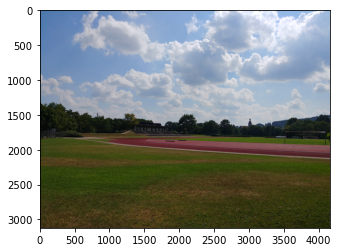

In [7]:
img = plt.imread(os.path.join(data_dir, os.listdir(data_dir)[5], os.listdir(data_dir+os.listdir(data_dir)[5])[0]))
plt.imshow(img)

In [8]:
PATCH_SIZE = 256

In [9]:
w, h, _ = img.shape
w_num_patch = w//PATCH_SIZE
h_num_patch = h//PATCH_SIZE
w_num_patch, h_num_patch

(12, 16)

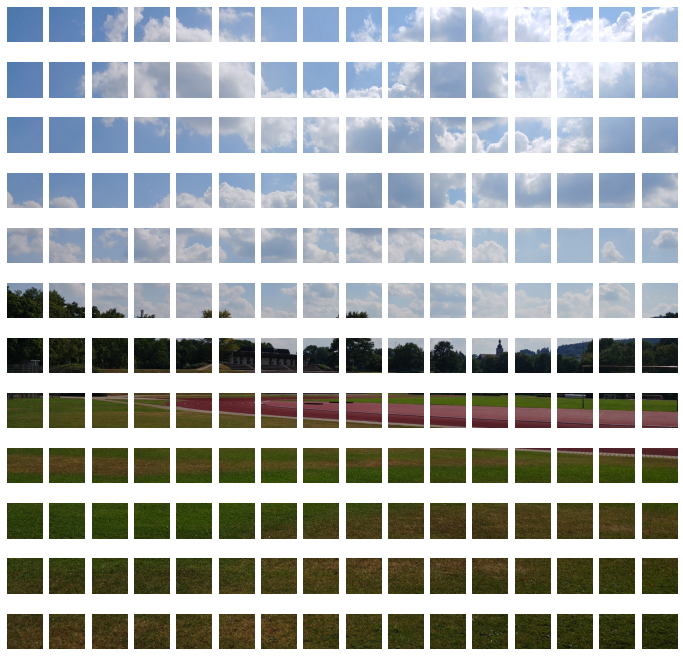

In [10]:
fig, ax = plt.subplots(w_num_patch, h_num_patch, figsize=(12, 12))
for i in range(w_num_patch):
    for j in range(h_num_patch):
        ax[i][j].imshow(img[i*PATCH_SIZE:(i+1)*PATCH_SIZE, j*PATCH_SIZE:(j+1)*PATCH_SIZE, :])
        ax[i][j].axis('off')

In [ ]:
if os.path.exists("D:\College\Projects\Source Camera Identification\PatchDataset\\"):
    for i in range(w_num_patch):
        for j in range(h_num_patch):
            print("Saving image", i*h_num_patch+j)
            plt.imsave(f"D:\College\Projects\Source Camera Identification\PatchDataset\img-{i*h_num_patch+j}.jpg", img[i*PATCH_SIZE:(i+1)*PATCH_SIZE, j*PATCH_SIZE:(j+1)*PATCH_SIZE, :])

In [13]:
# for dir_ in os.listdir(data_dir):
for dir_ in os.listdir(data_dir):
    if not os.path.exists(os.path.join("D:\College\Projects\Source Camera Identification\\256x256\\", dir_)):
        os.mkdir(os.path.join("D:\College\Projects\Source Camera Identification\\256x256\\", dir_))
    for file_ in os.listdir(os.path.join(data_dir, dir_)):
        k=0
        img = plt.imread(os.path.join(data_dir, dir_, file_))
        if img is None:
            continue
        file_name = file_.split(".jpg")[0]
        w, h, _ = img.shape
        w_num_patch = w//PATCH_SIZE
        h_num_patch = h//PATCH_SIZE
        for i in tqdm(range(w_num_patch), desc=file_name):
            for j in range(h_num_patch):
                plt.imsave(f"D:\College\Projects\Source Camera Identification\\256x256\\{dir_}\\{file_name}-{k:06}.jpg", img[i*PATCH_SIZE:(i+1)*PATCH_SIZE, j*PATCH_SIZE:(j+1)*PATCH_SIZE, :])
                k += 1
        del img

    print("")

D01_img_orig_0068: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 21.90it/s]


D01_img_orig_0136: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 20.91it/s]


D01_img_orig_0143: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 22.36it/s]


D02_img_orig_0068: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 32.24it/s]


D02_img_orig_0136: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.84it/s]


D02_img_orig_0143: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 31.28it/s]


D03_img_orig_0068: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 26.15it/s]


D03_img_orig_0136: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 23.12it/s]


D03_img_orig_0143: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 26.30it/s]


D04_img_orig_0069: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.23it/s]


D04_img_orig_0137: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.83it/s]


D04_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.96it/s]


D05_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 16.75it/s]


D05_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.85it/s]


D05_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 16.28it/s]


D06_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.13it/s]


D06_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.14it/s]


D06_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.72it/s]


D07_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21.36it/s]


D07_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 19.38it/s]


D07_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21.19it/s]


D08_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.31it/s]


D08_img_orig_0137: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.53it/s]


D08_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.41it/s]


D09_img_orig_0068: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 27.96it/s]


D09_img_orig_0136: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 24.74it/s]


D09_img_orig_0143: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 24.20it/s]


D10_img_orig_0068: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 31.33it/s]


D10_img_orig_0137: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 31.23it/s]


D10_img_orig_0143: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 32.21it/s]


D11_img_orig_0068: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 25.76it/s]


D11_img_orig_0136: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 25.11it/s]


D11_img_orig_0143: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 26.47it/s]


D12_img_orig_0068: 100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 50.40it/s]


D12_img_orig_0136: 100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 49.42it/s]


D12_img_orig_0143: 100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 51.88it/s]


D13_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.65it/s]


D13_img_orig_0137: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 19.24it/s]


D13_img_orig_0142: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 19.79it/s]


D14_img_orig_0068: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 31.48it/s]


D14_img_orig_0137: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 30.15it/s]


D14_img_orig_0143: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 29.58it/s]


D15_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 17.17it/s]


D15_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 14.51it/s]


D15_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.61it/s]


D16_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 17.12it/s]


D16_img_orig_0137: 100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.17it/s]


D16_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 17.72it/s]


D17_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.87it/s]


D17_img_orig_0137: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.30it/s]


D17_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21.33it/s]


D18_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.80it/s]


D18_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.76it/s]


D18_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.12it/s]


D19_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.84it/s]


D19_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 19.68it/s]


D19_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21.08it/s]


D20_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.99it/s]


D20_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 17.96it/s]


D20_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.66it/s]


D21_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 18.86it/s]


D21_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 19.72it/s]


D21_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21.45it/s]


D22_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.69it/s]


D22_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.99it/s]


D22_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.73it/s]


D23_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.36it/s]


D23_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.34it/s]


D23_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.44it/s]


D24_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.61it/s]


D24_img_orig_0137: 100%|███████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 26.68it/s]


D24_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.34it/s]


D25_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.31it/s]


D25_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.73it/s]


D25_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.73it/s]


D26_img_orig_0069: 100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 17.53it/s]


D26_img_orig_0137: 100%|███████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 22.75it/s]


D26_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 17.60it/s]


D27_img_orig_0068: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.48it/s]


D27_img_orig_0136: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 19.49it/s]


D27_img_orig_0143: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21.38it/s]

In [ ]:
type(img)